###**Ensemble of VGG19, InceptionV3 and VGG16 pretrained models.**
Created by : Apoorva Dattatray Bhandari
Student Number : 20235788


In [2]:
#all necessary imports

import numpy as np 
import pandas as pd 
import os
from glob import glob
from cv2 import resize
from cv2 import imread
from cv2 import INTER_CUBIC
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import random
import cv2
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, ReLU, Dropout,Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.constraints import unit_norm
from tensorflow.keras import regularizers
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import random
import cv2
from sklearn.metrics import accuracy_score


In [ ]:
#drive needed to access dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#loads the images located under the given path returns them in a list together with array of image's shapes 
def load_images(path):
    imglist, imgshapelist = list(), list()
    for impath in glob(path):
        img = imread(impath)
        if img.shape[2]==3:
            imglist.append(img)
            imgshapelist.append(img.shape)
    return imglist, np.array(imgshapelist)[:,:2]

#get images and shapes
cposl, cpshape = load_images("/content/drive/MyDrive/SARS_COVID_DATASET/COVID/*")
cnegl, cnshape = load_images("/content/drive/MyDrive/SARS_COVID_DATASET/non-COVID/*")

concatenated = np.concatenate([cpshape,cnshape])
concatenatedhwratios = concatenated[:,0]/concatenated[:,1]
q1 = np.quantile(concatenatedhwratios, .25, axis = 0)
q2 = np.quantile(concatenatedhwratios, .50, axis = 0)
q3 = np.quantile(concatenatedhwratios, .75, axis = 0)
qr = (q3-q1)*1.5
ql = q2 - qr
qu = q2 + qr

#outlier filters
cphwratios = cpshape[:,0]/cpshape[:,1]
cpfilter = (cphwratios<qu) & (cphwratios>ql)

cnhwratios = cnshape[:,0]/cnshape[:,1]
cnfilter = (cnhwratios<qu) & (cnhwratios>ql)


from itertools import compress
#returns an array of resized images that are not outliers 
def filter_resize_array(listofimages, filterofwanteds, targetdim, interpolation = INTER_CUBIC):
    retlis = list()
    for im in compress(listofimages, filterofwanteds):
        #midimg = cv2.resize(im, middim, interpolation)
        retlis.append(resize(im, targetdim, interpolation))
    return np.array(retlis)

#get resized appropriate images
cpos = filter_resize_array(cposl, cpfilter, (224, 224))
cneg = filter_resize_array(cnegl, cnfilter, (224, 224))

In [4]:
X = np.concatenate([cpos,cneg])

#create the Y array positive = [1 , 0] negative = [0 , 1]
Y = np.tile( np.array([0,0]),(X.shape[0],1))
Y[:cpos.shape[0],0]=1
Y[cpos.shape[0]:,1]=1


#shuffle
np.random.seed(1)
p = np.random.permutation(Y.shape[0])
X, Y = X[p], Y[p] 

#train test split
from sklearn.model_selection import train_test_split
xtr, xte, ytr, yte = train_test_split(X,Y,train_size = 0.85, random_state = 1)
xtr = xtr /255
xte = xte /255

##VGG19 pretrained model with addition of custom layers

In [ ]:
from keras.applications.vgg19 import VGG19
model = VGG19(include_top=False, weights='imagenet',input_shape=(224,224,3))
model.trainable = True
#flat1 = Flatten(name="vgg19_flat1")(model.output)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(model.output)
class1 = Dense(100, activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(l=0.001))(global_average_layer)
batch1 = BatchNormalization()(class1)
class2 = Dense(100, activation='relu',kernel_constraint=unit_norm())(batch1)
batch2 = BatchNormalization()(class2)
class3 = Dense(100, activation='relu',kernel_regularizer=regularizers.l2(l=0.01))(batch2)
output = Dense(2, activation='softmax')(class3)
model = Model(inputs=model.inputs, outputs=output)

model.compile(loss = "categorical_crossentropy", optimizer = keras.optimizers.Adamax(learning_rate=0.00001), metrics = ["accuracy"])

In [ ]:
epochs = 15
history = model.fit(xtr, ytr ,epochs = epochs, workers=10, validation_data=(xte, yte),use_multiprocessing=True)

Epoch 1/15
61/61 [==============================] - 83s 1s/step - loss: 1.7155 - accuracy: 0.7504 - val_loss: 1.8637 - val_accuracy: 0.5116
Epoch 2/15
61/61 [==============================] - 62s 1s/step - loss: 1.5045 - accuracy: 0.8863 - val_loss: 1.8325 - val_accuracy: 0.5203
Epoch 3/15
61/61 [==============================] - 62s 1s/step - loss: 1.4234 - accuracy: 0.9171 - val_loss: 1.7727 - val_accuracy: 0.6541
Epoch 4/15
61/61 [==============================] - 62s 1s/step - loss: 1.3712 - accuracy: 0.9418 - val_loss: 1.6792 - val_accuracy: 0.7733
Epoch 5/15
61/61 [==============================] - 62s 1s/step - loss: 1.3370 - accuracy: 0.9671 - val_loss: 1.5827 - val_accuracy: 0.8576
Epoch 6/15
61/61 [==============================] - 62s 1s/step - loss: 1.3100 - accuracy: 0.9722 - val_loss: 1.4833 - val_accuracy: 0.9128
Epoch 7/15
61/61 [==============================] - 62s 1s/step - loss: 1.2868 - accuracy: 0.9835 - val_loss: 1.3963 - val_accuracy: 0.9448
Epoch 8/15
61/61 [==

In [ ]:
model.save('VGG19.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/latest models/VGG19.h5')

In [ ]:
train_accu = model.evaluate(xtr,ytr)
print('The training accuracy is :',train_accu[1]*100, '%')

61/61 [==============================] - 26s 420ms/step - loss: 1.1653 - accuracy: 1.0000
The training accuracy is : 100.0 %


In [ ]:
test_accu = model.evaluate(xte,yte)
print('The testing accuracy is :',test_accu[1]*100, '%')

11/11 [==============================] - 3s 291ms/step - loss: 1.2345 - accuracy: 0.9651
The testing accuracy is : 96.51162624359131 %


In [ ]:
plt.plot(history.history['accuracy'],"g",label="Training Accuracy")
plt.plot(history.history['val_accuracy'],"b",label="Validation Accuracy")
plt.title('VGG19 Training and Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()
# "Loss"
plt.plot(history.history['loss'],"g",label="Training loss")
plt.plot(history.history['val_loss'],"b",label="Validation loss")
plt.title('VGG19 Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

##INCEPTIONV3 pretrained model with addition of custom layers


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
model = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
model.trainable = True
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(model.output)
class1 = Dense(100, activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(l=0.001))(global_average_layer)
batch1 = BatchNormalization()(class1)
class2 = Dense(100, activation='relu',kernel_constraint=unit_norm())(batch1)
batch2 = BatchNormalization()(class2)
class3 = Dense(100, activation='relu',kernel_regularizer=regularizers.l2(l=0.01))(batch2)
output = Dense(2, activation='softmax')(class3)
model = Model(inputs=model.inputs, outputs=output)

model.compile(loss = "categorical_crossentropy", optimizer = keras.optimizers.Adamax(learning_rate=0.00001), metrics = ["accuracy"])

In [ ]:

history=model.fit(xtr, ytr ,epochs = 30, workers=10, validation_data=(xte, yte),use_multiprocessing=True)

Epoch 1/30
61/61 [==============================] - 56s 720ms/step - loss: 2.0332 - accuracy: 0.5548 - val_loss: 1.9125 - val_accuracy: 0.5523
Epoch 2/30
61/61 [==============================] - 37s 608ms/step - loss: 1.9178 - accuracy: 0.6032 - val_loss: 1.9210 - val_accuracy: 0.5087
Epoch 3/30
61/61 [==============================] - 37s 607ms/step - loss: 1.8307 - accuracy: 0.6603 - val_loss: 1.9088 - val_accuracy: 0.5058
Epoch 4/30
61/61 [==============================] - 37s 608ms/step - loss: 1.7713 - accuracy: 0.7077 - val_loss: 1.9221 - val_accuracy: 0.5320
Epoch 5/30
61/61 [==============================] - 37s 607ms/step - loss: 1.7157 - accuracy: 0.7344 - val_loss: 1.9004 - val_accuracy: 0.5640
Epoch 6/30
61/61 [==============================] - 37s 607ms/step - loss: 1.6751 - accuracy: 0.7833 - val_loss: 1.8881 - val_accuracy: 0.5785
Epoch 7/30
61/61 [==============================] - 37s 606ms/step - loss: 1.6332 - accuracy: 0.8024 - val_loss: 1.8687 - val_accuracy: 0.5843

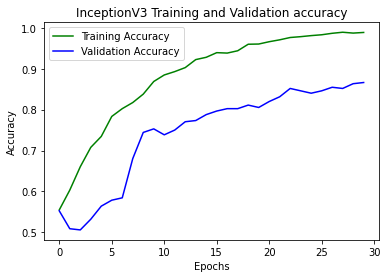

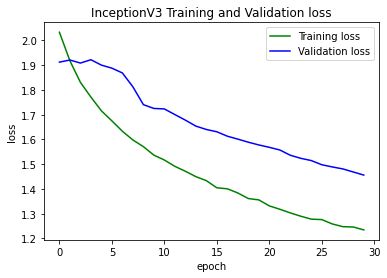

In [ ]:
plt.plot(history.history['accuracy'],"g",label="Training Accuracy")
plt.plot(history.history['val_accuracy'],"b",label="Validation Accuracy")
plt.title('InceptionV3 Training and Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()
# "Loss"
plt.plot(history.history['loss'],"g",label="Training loss")
plt.plot(history.history['val_loss'],"b",label="Validation loss")
plt.title('InceptionV3 Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/latest models/Inception_Model.h5')

In [ ]:
train_accu = model.evaluate(xtr,ytr)
print('The training accuracy is :',train_accu[1]*100, '%')

61/61 [==============================] - 12s 198ms/step - loss: 1.1790 - accuracy: 0.9969
The training accuracy is : 99.69120025634766 %


In [ ]:
train_accu = model.evaluate(xte,yte)
print('The testing accuracy is :',train_accu[1]*100, '%')

11/11 [==============================] - 7s 328ms/step - loss: 1.4561 - accuracy: 0.8663
The testing accuracy is : 86.62790656089783 %


###VGG16 pretrained model with addition of custom layers

In [ ]:
from tensorflow.keras.applications import VGG16
model = VGG16(include_top=False, input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model.trainable = True
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(model.output)
class1 = Dense(100, activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(l=0.001))(global_average_layer)
batch1 = BatchNormalization()(class1)
class2 = Dense(100, activation='relu',kernel_constraint=unit_norm())(batch1)
batch2 = BatchNormalization()(class2)
class3 = Dense(100, activation='relu',kernel_regularizer=regularizers.l2(l=0.01))(batch2)
output = Dense(2, activation='softmax')(class3)
model = Model(inputs=model.inputs, outputs=output)

model.compile(loss = "categorical_crossentropy", optimizer = keras.optimizers.Adamax(learning_rate=0.00001), metrics = ["accuracy"])

In [ ]:
history=model.fit(xtr, ytr ,epochs = 20, workers=10, validation_data=(xte, yte),use_multiprocessing=True)

Epoch 1/20
61/61 [==============================] - 85s 1s/step - loss: 1.6189 - accuracy: 0.7993 - val_loss: 1.8698 - val_accuracy: 0.5116
Epoch 2/20
61/61 [==============================] - 52s 851ms/step - loss: 1.4532 - accuracy: 0.9115 - val_loss: 1.8357 - val_accuracy: 0.5116
Epoch 3/20
61/61 [==============================] - 52s 851ms/step - loss: 1.3894 - accuracy: 0.9336 - val_loss: 1.7621 - val_accuracy: 0.5814
Epoch 4/20
61/61 [==============================] - 52s 850ms/step - loss: 1.3413 - accuracy: 0.9619 - val_loss: 1.6655 - val_accuracy: 0.8517
Epoch 5/20
61/61 [==============================] - 52s 850ms/step - loss: 1.3124 - accuracy: 0.9722 - val_loss: 1.5985 - val_accuracy: 0.7907
Epoch 6/20
61/61 [==============================] - 52s 850ms/step - loss: 1.2907 - accuracy: 0.9794 - val_loss: 1.4770 - val_accuracy: 0.9244
Epoch 7/20
61/61 [==============================] - 52s 850ms/step - loss: 1.2689 - accuracy: 0.9820 - val_loss: 1.3975 - val_accuracy: 0.9390
Ep

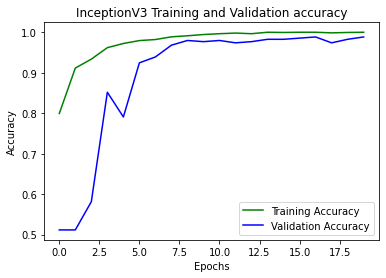

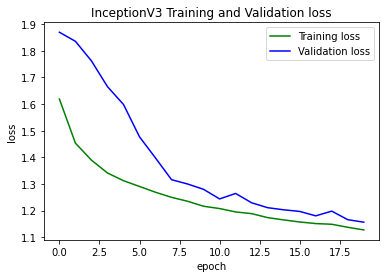

In [ ]:
plt.plot(history.history['accuracy'],"g",label="Training Accuracy")
plt.plot(history.history['val_accuracy'],"b",label="Validation Accuracy")
plt.title('InceptionV3 Training and Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()
# "Loss"
plt.plot(history.history['loss'],"g",label="Training loss")
plt.plot(history.history['val_loss'],"b",label="Validation loss")
plt.title('InceptionV3 Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
model.save('VGG16.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/latest models/VGG16.h5')

In [ ]:
train_accu = model.evaluate(xtr,ytr)
print('The training accuracy is :',train_accu[1]*100, '%')

61/61 [==============================] - 15s 246ms/step - loss: 1.1142 - accuracy: 1.0000
The training accuracy is : 100.0 %


In [ ]:
train_accu = model.evaluate(xte,yte)
print('The training accuracy is :',train_accu[1]*100, '%')

11/11 [==============================] - 3s 243ms/step - loss: 1.1566 - accuracy: 0.9884
The training accuracy is : 98.83720874786377 %


## Stacked Ensemble of VGG16, VGG19 and InceptionV3 models

In [3]:
def load_all_models():
    all_models = []
    model_names = ['/content/drive/MyDrive/latest models/Inception_Model.h5', '/content/drive/MyDrive/latest models/VGG16.h5','/content/drive/MyDrive/latest models/VGG19.h5']
    for model_name in model_names:
        filename = os.path.join('models', model_name)
        model = tf.keras.models.load_model(filename)
        all_models.append(model)
        print('loaded:', filename)
    return all_models
models = load_all_models()
for i, model in enumerate(models):
    for layer in model.layers:
        layer.trainable = False
        layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

loaded: /content/drive/MyDrive/latest models/Inception_Model.h5
loaded: /content/drive/MyDrive/latest models/VGG16.h5
loaded: /content/drive/MyDrive/latest models/VGG19.h5


In [4]:
ensemble_visible = [model.input for model in models]
ensemble_outputs = [model.output for model in models]
merge = tf.keras.layers.concatenate(ensemble_outputs)
merge = tf.keras.layers.Dense(2, activation='relu')(merge)
output = tf.keras.layers.Dense(2, activation='softmax')(merge)
model = tf.keras.models.Model(inputs=ensemble_visible, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [8]:
xtr = [xtr for _ in range(len(model.input))]
xte = [xte for _ in range(len(model.input))]

In [9]:
history=model.fit(xtr, ytr ,epochs = 30, workers=10, validation_data=(xte, yte),use_multiprocessing=True)

Epoch 1/30
61/61 [==============================] - 123s 1s/step - loss: 3.9909 - accuracy: 0.8806 - val_loss: 3.9996 - val_accuracy: 0.8634
Epoch 2/30
61/61 [==============================] - 51s 832ms/step - loss: 3.9296 - accuracy: 0.9974 - val_loss: 3.9484 - val_accuracy: 0.8837
Epoch 3/30
61/61 [==============================] - 51s 832ms/step - loss: 3.8633 - accuracy: 0.9985 - val_loss: 3.8925 - val_accuracy: 0.9012
Epoch 4/30
61/61 [==============================] - 51s 831ms/step - loss: 3.7989 - accuracy: 0.9969 - val_loss: 3.8389 - val_accuracy: 0.9302
Epoch 5/30
61/61 [==============================] - 51s 831ms/step - loss: 3.7411 - accuracy: 0.9974 - val_loss: 3.7898 - val_accuracy: 0.9390
Epoch 6/30
61/61 [==============================] - 51s 831ms/step - loss: 3.6918 - accuracy: 0.9985 - val_loss: 3.7469 - val_accuracy: 0.9419
Epoch 7/30
61/61 [==============================] - 50s 830ms/step - loss: 3.6507 - accuracy: 0.9985 - val_loss: 3.7091 - val_accuracy: 0.9506
E

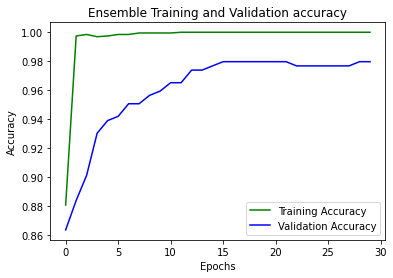

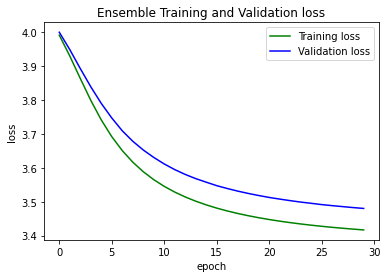

In [10]:
plt.plot(history.history['accuracy'],"g",label="Training Accuracy")
plt.plot(history.history['val_accuracy'],"b",label="Validation Accuracy")
plt.title('Ensemble Training and Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()
# "Loss"
plt.plot(history.history['loss'],"g",label="Training loss")
plt.plot(history.history['val_loss'],"b",label="Validation loss")
plt.title('Ensemble Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [5]:
model = tf.keras.models.load_model('/content/drive/MyDrive/latest models/PretrainedEnsemble.h5')


In [6]:
xtr = [xtr for _ in range(len(model.input))]
xte = [xte for _ in range(len(model.input))]

In [7]:
train_accu = model.evaluate(xtr,ytr)
print('The training accuracy is :',train_accu[1]*100, '%')

61/61 [==============================] - 97s 905ms/step - loss: 3.4540 - accuracy: 1.0000
The training accuracy is : 100.0 %


In [8]:
test_accu = model.evaluate(xte,yte)
print('The training accuracy is :',test_accu[1]*100, '%')

11/11 [==============================] - 20s 2s/step - loss: 3.5170 - accuracy: 0.9767
The training accuracy is : 97.67441749572754 %
